<a href="https://colab.research.google.com/github/pd1714git/QuintenCase1Group5/blob/master/airbus%7C_challenge_mask_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Upload data

In [0]:
!pip install *kaggle*

In [0]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import json
token = {"username":"pod1714","key":"b1a198266c43fb327f8ee53400f8e887"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json


In [0]:
!kaggle config set -n path -v{/content}


- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json


In [0]:
!kaggle competitions download -c airbus-ship-detection -p /content

  0% 0.00/274k [00:00<?, ?B/s]
100% 274k/274k [00:00<00:00, 41.7MB/s]
 67% 12.0M/18.0M [00:00<00:00, 125MB/s]
100% 18.0M/18.0M [00:00<00:00, 115MB/s]
 99% 2.11G/2.12G [00:12<00:00, 178MB/s]
100% 2.12G/2.12G [00:13<00:00, 174MB/s]
100% 26.4G/26.4G [03:19<00:00, 137MB/s]
100% 26.4G/26.4G [03:19<00:00, 142MB/s]


In [0]:
!mkdir input

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.data import imread
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os, zipfile
print(os.listdir("input"))

# Any results you write to the current directory are saved as output.

[]


In [0]:
!mkdir input/test

In [0]:
zip_ref = zipfile.ZipFile('test_v2.zip') # create zipfile object
zip_ref.extractall("input/test") # extract file to dir
zip_ref.close() 

In [0]:
!mkdir input/train

In [0]:
zip_ref = zipfile.ZipFile('train_ship_segmentations_v2.csv.zip') # create zipfile object
zip_ref.extractall("input") # extract file to dir
zip_ref.close() 

In [0]:
zip_ref = zipfile.ZipFile('train_v2.zip') # create zipfile object
zip_ref.extractall("input/train") # extract file to dir
zip_ref.close() 

In [0]:
os.rename("sample_submission_v2.csv", "input/sample_submission.csv")

# 2. Image mask first attempt

In [0]:
submission = pd.read_csv('input/sample_submission.csv')
submission.head()

,ImageId,EncodedPixels
0,00002bd58.jpg,1 2
1,00015efb6.jpg,1 2
2,00023d5fc.jpg,1 2
3,000367c13.jpg,1 2
4,0008ca6e9.jpg,1 2


In [0]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [0]:
masks = pd.read_csv('input/train_ship_segmentations_v2.csv')
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


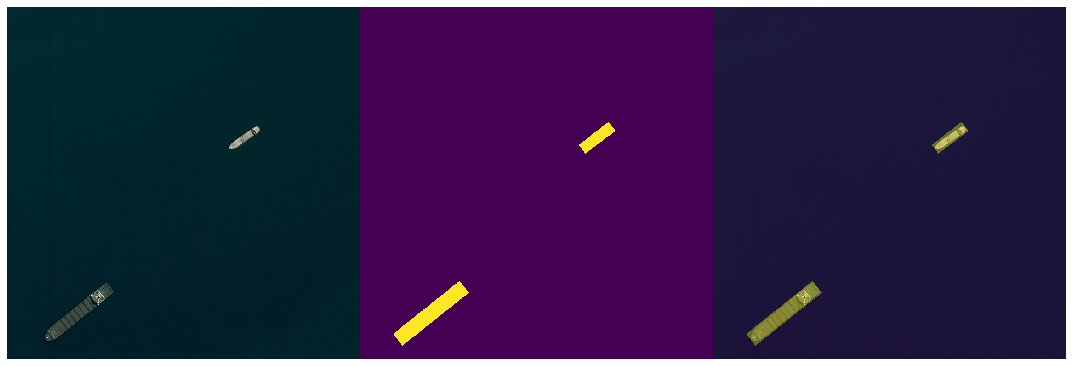

In [0]:
ImageId = '0005d01c8.jpg'

img = imread('input/train/' + ImageId)
img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

# Take the individual ship masks and create a single mask array for all ships
all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += rle_decode(mask)

fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()


In [0]:
all_masks.shape

(768, 768)

# 3. Mask, final version and data exploration

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from skimage.morphology import label
from skimage.data import imread

import os
import time
import sys

### 1. Set model parameters

In [0]:
IMAGE_WIDTH = 768
IMAGE_HEIGHT = 768
SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT)
TRAIN_DATA_PATH = os.path.join('input', 'train')
TEST_DATA_PATH = os.path.join('input', 'test')
TRAINING_VALIDATION_RATIO = 0.2
SHIP_CLASS_NAME = 'ship'

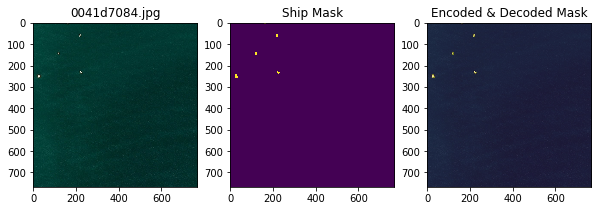

0041d7084.jpg


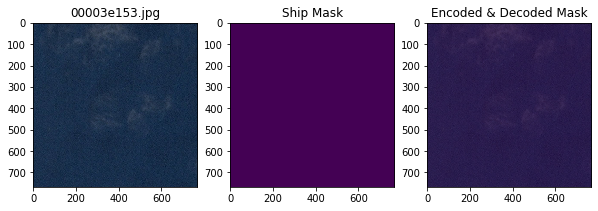

00003e153.jpg
It could be different when there is no mask.


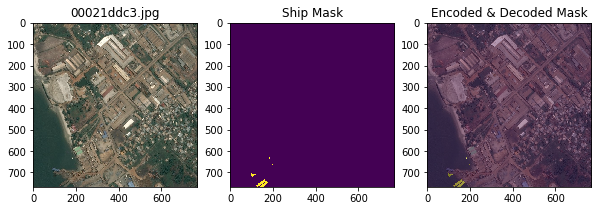

00021ddc3.jpg
It could be different when there are masks overlapped.


In [0]:
def masks_as_image(in_mask_list, shape=SHAPE):
    all_masks = np.zeros(shape, dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def shows_decode_encode(image_id, path=TRAIN_DATA_PATH):
   
    fig, axarr = plt.subplots(1, 3, figsize = (10, 5))
    img_0 = imread(os.path.join(path, image_id))
    axarr[0].imshow(img_0)
    axarr[0].set_title(image_id)
    rle_1 = masks.query('ImageId=="{}"'.format(image_id))['EncodedPixels']
    img_1 = masks_as_image(rle_1)
    axarr[1].imshow(img_1[:, :, 0])
    axarr[1].set_title('Ship Mask')
    axarr[2].imshow(img_0)
    axarr[2].imshow(img_1[:, :, 0], alpha=0.4)
    axarr[2].set_title('Encoded & Decoded Mask')
    plt.show()
    print(image_id )

shows_decode_encode('0041d7084.jpg')
shows_decode_encode('00003e153.jpg')
print('It could be different when there is no mask.')
shows_decode_encode('00021ddc3.jpg')
print('It could be different when there are masks overlapped.')

unique_img_ids groupby took: 25.424463510513306


,ImageId,ships,RleMaskList
178652,eda3bbd99.jpg,1,[173905 1 174672 4 175440 5 176207 8 176975 10...
96406,80265c555.jpg,2,[145484 1 146251 3 147017 6 147784 8 148551 9 ...
112516,959c658b6.jpg,1,[137871 7 138639 14 139407 14 140175 14 140943...


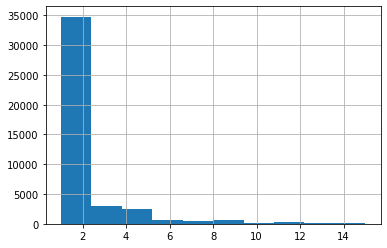

In [0]:
# Add ships column, 1 if encoded pixels are present 0 otherwise
masks['ships'] = masks['EncodedPixels'].map(lambda encoded_pixels: 1 if isinstance(encoded_pixels, str) else 0)

# Get Image characteristics
start_time = time.time()
# Count number of ships
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'})
# group the encoded list for pixels for each ship in one column
unique_img_ids['RleMaskList'] = masks.groupby('ImageId')['EncodedPixels'].apply(list)
unique_img_ids = unique_img_ids.reset_index()
end_time = time.time() - start_time
print("unique_img_ids groupby took: {}".format(end_time))
# eliminate empty arrays.
unique_img_ids = unique_img_ids[unique_img_ids['ships'] > 0]
unique_img_ids['ships'].hist()
unique_img_ids.sample(3)

34044 training masks
8512 validation masks


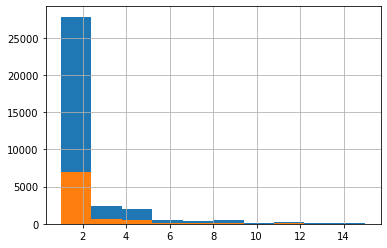

In [0]:
from sklearn.model_selection import train_test_split
train_ids, val_ids = train_test_split(unique_img_ids, 
                                      test_size = TRAINING_VALIDATION_RATIO, 
                                      stratify = unique_img_ids['ships']
                                      )
print(train_ids.shape[0], 'training masks')
print(val_ids.shape[0], 'validation masks')
train_ids['ships'].hist()
val_ids['ships'].hist()

In [0]:
train_ids.reset_index(inplace=True)
train_ids.drop('index',axis=1,inplace=True)
train_ids.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ImageId,ships,RleMaskList
0,19defa316.jpg,3,[465301 1 466068 3 466835 5 467601 8 468368 9 ...
1,8bd836442.jpg,2,[569773 2 570541 5 571308 8 572076 10 572844 1...
2,349e6e3ef.jpg,1,[386671 2 387438 3 388206 4 388975 3 389743 3 ...
3,828c0c31a.jpg,1,[552525 2 553291 4 554057 7 554823 9 555589 12...
4,98471569a.jpg,1,[305861 1 306628 4 307396 6 308163 9 308931 11...


In [0]:
# Create a directory with masks
!mkdir input/masks
!mkdir input/train_ship

In [0]:
!pip install scipy

## 3. Creating masks

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
!pip install fastai

In [0]:
from skimage.morphology import label
import json

In [0]:
torch.backends.cudnn.benchmark=True


In [0]:
PATH = 'input'

In [0]:
seg_df = pd.read_csv(os.path.join(PATH,'train_ship_segmentations_v2.csv'))

In [0]:
seg_df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [0]:
seg_df.shape


(231723, 2)

In [0]:
files = os.listdir(os.path.join(PATH,'train'))

In [0]:
len(files)

192556

In [0]:
def rle_encode(img, min_threshold=1e-3, max_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_threshold:
        return '' ## no need to encode if it's all zeros
    if max_threshold and np.mean(img) > max_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [0]:
def multi_rle_encode(img):
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2)) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

In [0]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [0]:
def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

In [0]:
def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

In [0]:
not_empty = pd.notna(seg_df.EncodedPixels)
not_empty.sum(), seg_df[not_empty].ImageId.nunique()

(81723, 42556)

In [0]:
(~not_empty).sum(), seg_df[~not_empty].ImageId.nunique()


(150000, 150000)

In [0]:
rle_0 = seg_df.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
img_0

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4
0 error


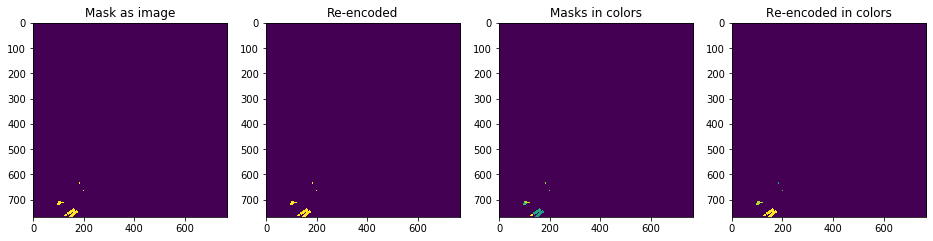

In [0]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 5))
rle_0 = seg_df.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0)
ax1.set_title('Mask as image')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1)
ax2.set_title('Re-encoded')
img_c = masks_as_color(rle_0)
ax3.imshow(img_c)
ax3.set_title('Masks in colors')
img_c = masks_as_color(rle_1)
ax4.imshow(img_c)
ax4.set_title('Re-encoded in colors')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))
print(np.sum(img_0 - img_1), 'error')

In [0]:
seg_df[not_empty].head()

,ImageId,EncodedPixels
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...


In [0]:
seg_df['ships'] = seg_df['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)

In [0]:
unique_img_ids = seg_df.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)

In [0]:
unique_img_ids.head()


,ImageId,ships,has_ship
0,00003e153.jpg,0,0.0
1,0001124c7.jpg,0,0.0
2,000155de5.jpg,1,1.0
3,000194a2d.jpg,5,1.0
4,0001b1832.jpg,0,0.0


In [0]:
ship_files = unique_img_ids[unique_img_ids.has_ship>0].ImageId.values

In [0]:
empty_files = unique_img_ids[unique_img_ids.has_ship==0].ImageId.values

In [0]:
len(ship_files), len(empty_files)


(42556, 150000)

In [0]:
seg_df[seg_df.ImageId.isin(ship_files)].head()

,ImageId,EncodedPixels,ships
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,1
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,1


In [0]:
len(seg_df[seg_df.ImageId.isin(ship_files)].ImageId.unique())


42556

In [0]:
samp_df = seg_df[seg_df.ImageId.isin(ship_files)].copy()


In [0]:
samp_df.reset_index(inplace=True)


In [0]:
samp_df.head()


,index,ImageId,EncodedPixels,ships
0,2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
1,3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
2,4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1
3,5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,1
4,6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,1


In [0]:
samp_unique = unique_img_ids[unique_img_ids.ImageId.isin(ship_files)]


In [0]:
samp_unique.head()


,ImageId,ships,has_ship
2,000155de5.jpg,1,1.0
3,000194a2d.jpg,5,1.0
5,00021ddc3.jpg,9,1.0
6,0002756f7.jpg,2,1.0
9,00031f145.jpg,1,1.0


In [0]:
len(samp_unique.ImageId.unique())


42556

In [0]:
samp_unique.shape, samp_df.shape


((42556, 3), (81723, 4))

In [0]:
enc_group = samp_df.groupby('ImageId')


In [0]:
image_fns = samp_unique.ImageId.values


In [0]:
def get_mask(im, gb):
    rle = gb.get_group(im).EncodedPixels
    im_mask = masks_as_image(rle)

    im_mask = im_mask*255
    out_mask = np.stack([im_mask, im_mask, im_mask], axis=2)

    out_im = Image.fromarray(out_mask)

    fn = f'{im[:-4]}_mask.png'
    out_im.save(os.path.join(PATH,'masks',fn), "PNG")

In [0]:
def multi_masks(filenames, gb):
    with ThreadPoolExecutor(8) as e:
        e.map(lambda x: get_mask(x, gb), filenames)

In [0]:
%time multi_masks(image_fns, enc_group)

In [0]:
a = os.listdir('input/masks')
len(a)

42556

In [0]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class AirbusShipDetectionPytorch(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "train_unique"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "train_unique", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        mask = np.array(mask)[:,:,0]

        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

In [0]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version


In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [0]:
# use our dataset and defined transformations
dataset = AirbusShipDetectionPytorch('input', get_transform(train=True))
dataset_test = AirbusShipDetectionPytorch('input', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(20)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,
                            momentum=0.9, weight_decay=0.05)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [0]:
# let's train it for 10 epochs
import time
num_epochs = 5
start_time = time.time()
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1000)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
end_time = time.time()

Epoch: [0]  [    0/21253]  eta: 6:21:12  lr: 0.000020  loss: 0.8907 (0.8907)  loss_classifier: 0.0258 (0.0258)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.7292 (0.7292)  loss_objectness: 0.1178 (0.1178)  loss_rpn_box_reg: 0.0179 (0.0179)  time: 1.0762  data: 0.6278  max mem: 4938
Epoch: [0]  [ 1000/21253]  eta: 1:37:05  lr: 0.010000  loss: 0.7660 (0.8377)  loss_classifier: 0.0302 (0.0376)  loss_box_reg: 0.0027 (0.0124)  loss_mask: 0.4579 (0.5104)  loss_objectness: 0.1319 (0.2047)  loss_rpn_box_reg: 0.0334 (0.0725)  time: 0.2812  data: 0.0096  max mem: 4938
Epoch: [0]  [ 2000/21253]  eta: 1:32:03  lr: 0.010000  loss: 0.9528 (0.8553)  loss_classifier: 0.0232 (0.0398)  loss_box_reg: 0.0000 (0.0133)  loss_mask: 0.5308 (0.5205)  loss_objectness: 0.2629 (0.2071)  loss_rpn_box_reg: 0.0948 (0.0747)  time: 0.2848  data: 0.0104  max mem: 4938
Epoch: [0]  [ 3000/21253]  eta: 1:27:12  lr: 0.010000  loss: 0.8975 (0.8721)  loss_classifier: 0.0348 (0.0395)  loss_box_reg: 0.0000 (0.0132)  loss_mask: 

In [0]:
print(end_time-start_time)

NameError: ignored

In [0]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [0]:
prediction

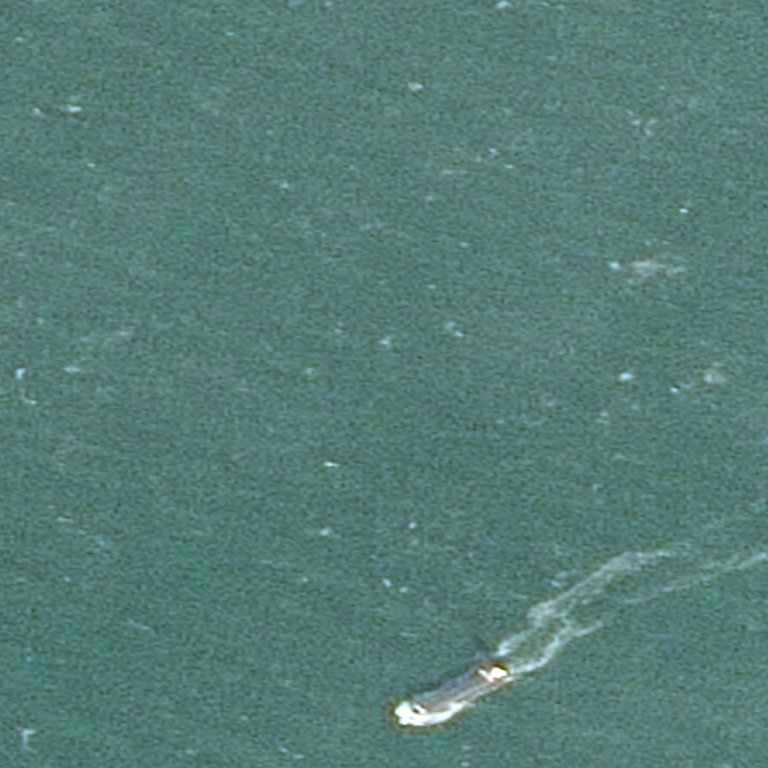

In [0]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

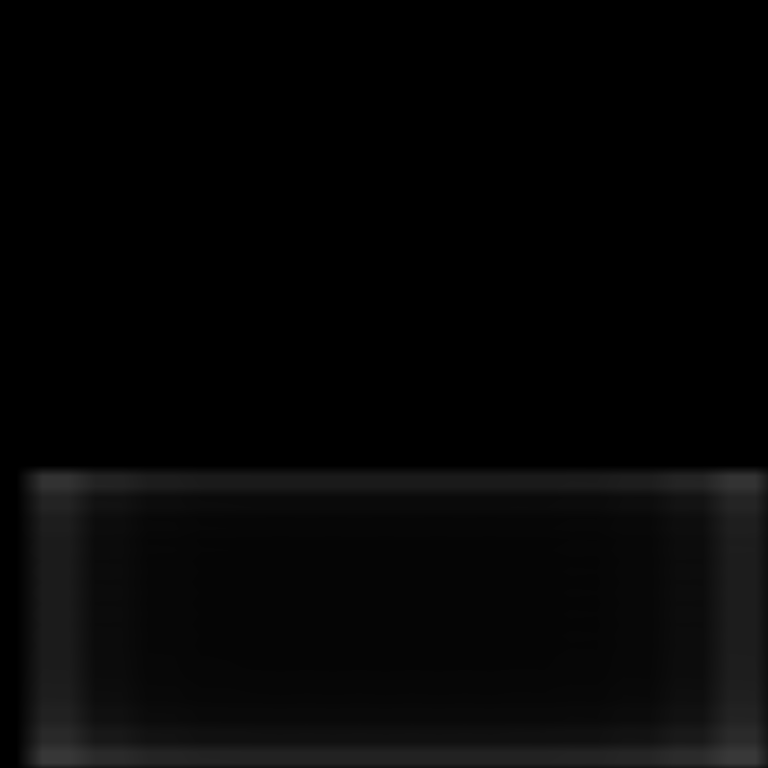

In [0]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [0]:
7